Commençons par charger et inspecter vos données.

In [14]:
import pandas as pd

# Charger les données à partir du fichier CSV
file_path = 'Danube ammonium level Time Series.csv'
data=pd.read_csv(file_path, sep=';')

# Afficher les premières lignes pour comprendre la structure des données
data.head()


,Months,Ammonium
0,01/01/1996,"0,253333"
1,01/02/1996,"0,218889"
2,01/03/1996,"0,242"
3,01/04/1996,"0,134545"
4,01/05/1996,"0,113333"


question  1


In [15]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Charger les données
file_path = 'Danube ammonium level Time Series.csv'
data = pd.read_csv(file_path, sep=';', parse_dates=['Months'], dayfirst=True)
data['Ammonium'] = data['Ammonium'].str.replace(',', '.').astype(float)

# Séparer les données pour l'apprentissage et le test
train_data = data[(data['Months'] >= '1996-01-01') & (data['Months'] <= '2016-12-01')]
test_data = data[(data['Months'] >= '2017-01-01') & (data['Months'] <= '2017-12-01')]

# Normaliser les données
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data[['Ammonium']])
test_data_scaled = scaler.transform(test_data[['Ammonium']])

# Les données normalisées sont maintenant dans train_data_scaled et test_data_scaled


Pour préparer les données pour un réseau de neurones récurrent (RNN), on va les structurer de manière à ce que chaque observation contienne le taux d'ammonium à un instant t et le taux à l'instant t+1. Ce code définit une fonction create_dataset, qui transforme les données normalisées en paires (t, t+1). look_back est le nombre de pas de temps précédents à utiliser pour prédire la valeur suivante, ici réglé à 1. Les données d'apprentissage et de test sont ensuite transformées en utilisant cette fonction.

In [16]:
import numpy as np

def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Créer les ensembles de données pour l'apprentissage et le test
look_back = 1
X_train, Y_train = create_dataset(train_data_scaled, look_back)
X_test, Y_test = create_dataset(test_data_scaled, look_back)

On construit un RNN 

In [17]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(SimpleRNN(hp.Int('units', min_value=32, max_value=512, step=16), 
                        activation=hp.Choice('activation', values=['relu', 'tanh']),
                        input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # nombre de configurations à tester
    executions_per_trial=3,  # nombre d'itérations par configuration
    directory='my_dir',
    project_name='keras_tuner_demo'
)

tuner.search(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

# Récupérer le meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]

# Entraîner le meilleur modèle
best_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

# Faire des prédictions avec le meilleur modèle
predictions = best_model.predict(X_test)

# Inverser la normalisation pour obtenir les vrais taux d'ammonium
predictions_inverse = scaler.inverse_transform(predictions)
true_predictions = scaler.inverse_transform(predictions.reshape(-1, 1))


Reloading Tuner from my_dir\keras_tuner_demo\tuner0.json
Epoch 1/100
8/8 [==============================] - 1s 1ms/step - loss: 0.0265
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0226
Epoch 3/100
8/8 [==============================] - 0s 0s/step - loss: 0.0218
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0198
Epoch 5/100
8/8 [==============================] - 0s 716us/step - loss: 0.0188
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 8/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0177
Epoch 9/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0177
Epoch 10/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0176
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 12/100
8/8 [==============================] - 0s 0s/step - loss: 0.0175
Epoc

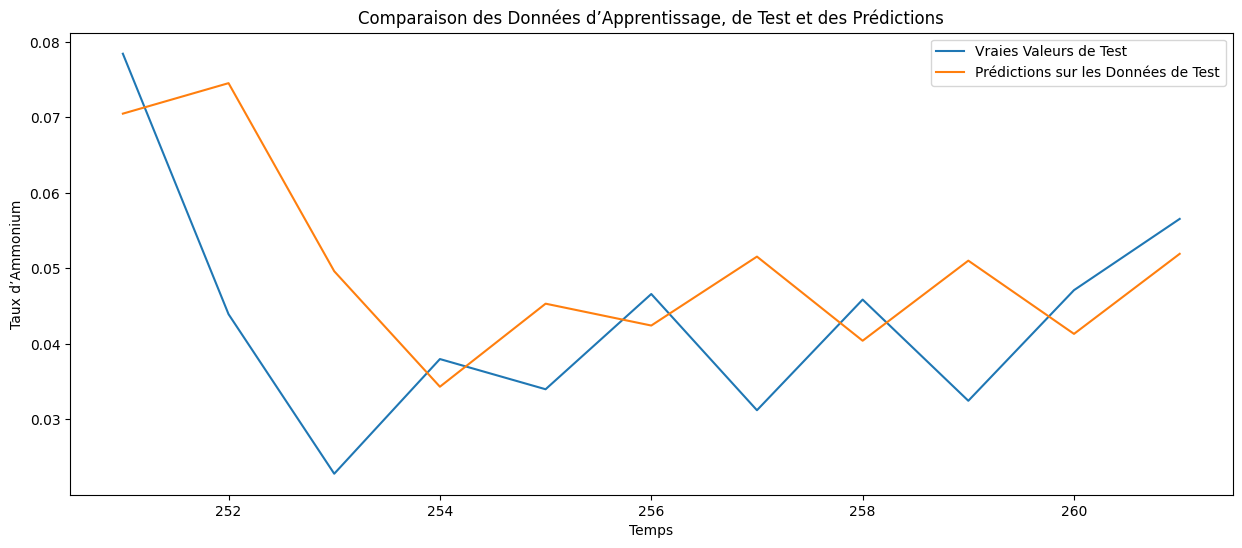

In [18]:
import matplotlib.pyplot as plt

# Comparer les vraies valeurs avec les prédictions
true_values = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Inverser la normalisation pour les données d'apprentissage
true_train = scaler.inverse_transform(Y_train.reshape(-1, 1))

# Préparer les indices de temps pour le traçage
time_train = range(len(true_train))
time_test = range(len(true_train), len(true_train) + len(true_predictions))

# Tracer les données d'apprentissage et de test avec les prédictions
plt.figure(figsize=(15, 6))
#plt.plot(time_train, true_train, label='Données d’Apprentissage Réelles')
plt.plot(time_test, true_values, label='Vraies Valeurs de Test')
plt.plot(time_test, true_predictions, label='Prédictions sur les Données de Test')
plt.title('Comparaison des Données d’Apprentissage, de Test et des Prédictions')
plt.xlabel('Temps')
plt.ylabel('Taux d’Ammonium')
plt.legend()
plt.show()


affichage des meilluers hyperparametres

In [19]:
# Récupérer les meilleurs hyperparamètres
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres:")
print("Nombre de neurones dans la couche RNN (units):", best_hp.get('units'))
print("Fonction d'activation pour la couche RNN (activation):", best_hp.get('activation'))

# Vous pouvez également afficher d'autres hyperparamètres si vous les avez inclus dans votre recherche


Meilleurs hyperparamètres:
Nombre de neurones dans la couche RNN (units): 64
Fonction d'activation pour la couche RNN (activation): tanh


Calcul des mesures de performance

In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calcul du MSE et du RMSE
mse = mean_squared_error(true_values, true_predictions)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)


MSE: 0.00024736792316439445
RMSE: 0.015727934484998162


Cela semble plutot bon même si sans comparaison c'est dur de savoir

Analyse des Résidus :

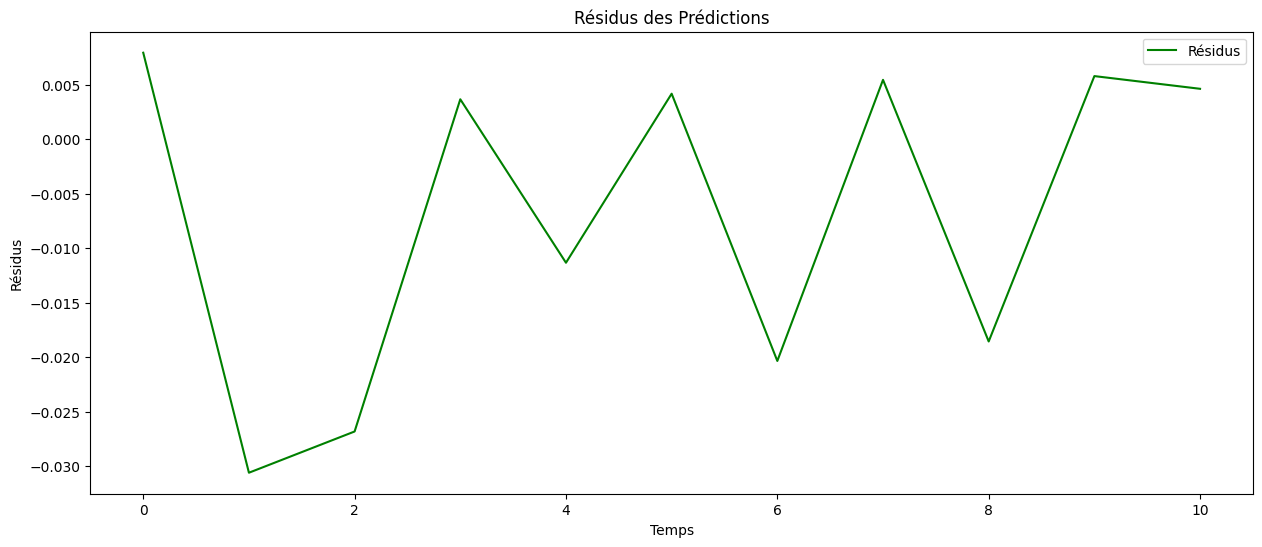

In [21]:
# Calcul des résidus
residuals = true_values - true_predictions

# Tracer les résidus
plt.figure(figsize=(15, 6))
plt.plot(residuals, label='Résidus', color='green')
plt.title('Résidus des Prédictions')
plt.xlabel('Temps')
plt.ylabel('Résidus')
plt.legend()
plt.show()


Affichage de la distribution des erreurs en therme de frequence

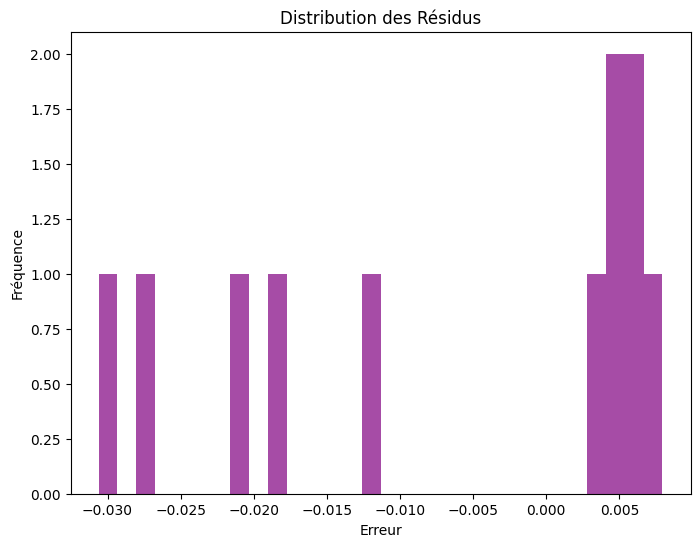

In [22]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='purple', alpha=0.7)
plt.title('Distribution des Résidus')
plt.xlabel('Erreur')
plt.ylabel('Fréquence')
plt.show()


L'histogramme montre une distribution des résidus du modèle RNN qui indique une légère tendance à la sous-estimation des prévisions. La concentration des résidus autour d'une valeur positive suggère que le modèle pourrait bénéficier d'un ajustement pour corriger ce biais. Cela pourrait impliquer une réévaluation de la structure du modèle ou de l'approche d'entraînement pour obtenir une distribution plus centrée autour de zéro, reflétant des erreurs aléatoires plutôt que systématiques.

model ARIMA

In [25]:
from pmdarima import auto_arima

# Assurez-vous que la colonne 'Ammonium' est de type numérique
train_series = pd.to_numeric(train_data['Ammonium'], errors='coerce').dropna()

# Exécution de auto_arima pour trouver les meilleurs paramètres de modèle ARIMA
best_model_autoarima = auto_arima(train_series, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# Afficher le résumé du meilleur modèle
print(best_model_autoarima.summary())

# Faire des prédictions
predictions_arima = best_model_autoarima.predict(n_periods=len(test_data)-1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-937.677, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-945.649, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-945.886, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-939.552, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-945.530, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-954.531, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-994.737, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-993.779, Time=0.21 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-1001.686, Time=0.26 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-998.801, Time=0.32 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-1000.931, Time=0.25 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=-1003.312, Time=0.37 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AI

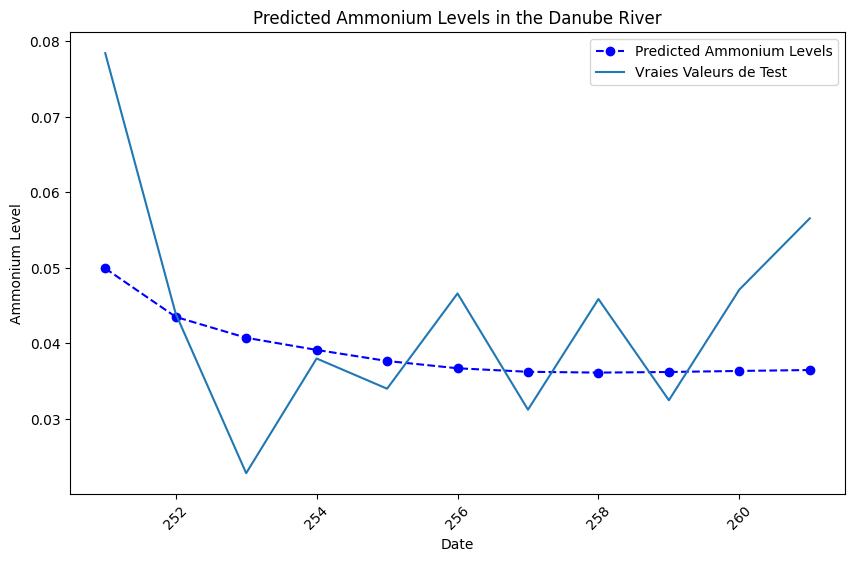

In [27]:
import matplotlib.pyplot as plt

# Plotting the predicted time series
plt.figure(figsize=(10, 6))
plt.plot(time_test, predictions_arima, color='blue', marker='o', linestyle='dashed', label='Predicted Ammonium Levels')
plt.plot(time_test, true_values, label='Vraies Valeurs de Test')

plt.title('Predicted Ammonium Levels in the Danube River')
plt.xlabel('Date')
plt.ylabel('Ammonium Level')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [28]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'true_values' contains the actual values from your test data
# and 'predictions_arima' contains the predicted values from your ARIMA model
# true_values = [your actual values array]
# predictions_arima = [your predicted values array]

# Calculating Mean Squared Error (MSE)
mse = mean_squared_error(true_values, predictions_arima)

# Calculating Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)


MSE: 0.0001728292796311776
RMSE: 0.013146455021456454


Les résultats montrent que le modèle ARIMA (MSE: 0.0001728, RMSE: 0.01315) a légèrement mieux performé que le RNN (MSE: 0.0002474, RMSE: 0.01573). Ces résultats suggèrent que pour des séries temporelles moins complexes ou de petite taille, les méthodes statistiques traditionnelles comme ARIMA pourraient être préférables. Cependant, dans des contextes de données plus vastes et complexes, l'exploration de modèles de réseaux de neurones plus avancés pourrait être bénéfique.